<div style="float:right; padding-top: 15px; padding-right: 15px">
    <div>
        <a href="https://whiteboxml.com">
            <img src="https://whiteboxml.com/static/img/logo/black_bg_white.svg" width="250">
        </a>
    </div>
</div>

# NLP Gamereactor clustering

## 0. python imports

In [35]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

from hdbscan import HDBSCAN
from spacy.lang.es.stop_words import STOP_WORDS
from spacy.lang.es import Spanish
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from umap import UMAP

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

## 1. data loading

list of titles of best 100 films ever made...

In [36]:
gamereactor_df = pd.read_csv('../data/gamereactor_data.csv')

gamereactor_df[:3]

,title,author,review,url
0,Kingdoms of Amalur: Re-Reckoning,Roy Woodhouse,Sé que no todo el mundo lo recibió igual de bi...,https://www.gamereactor.es/kingdoms-of-amalur-...
1,Tennis World Tour 2 - Iguales,Daniel Andersen,Habían pasado muchos años sin que los fans de ...,https://www.gamereactor.es/tennis-world-tour-2...
2,Hades,Ricardo C. Esteves,El periplo por un limbo llamado acceso anticip...,https://www.gamereactor.es/hades-analisis/?sid...


In [37]:
gamereactor_df.dtypes

title     object
author    object
review    object
url       object
dtype: object

In [38]:
synopses = gamereactor_df['review']

In [39]:
#synopses = open('data/synopses_list.txt').read().split('\n BREAKS HERE')[0:100]

synopses[:1]

0    Sé que no todo el mundo lo recibió igual de bi...
Name: review, dtype: object

## 2. data processing

In [14]:
nlp = spacy.load("es_core_news_md")

# do something with the model, e.g. tokenize the text
#doc = nlp(synopses[0])
#for token in doc:
#    print(token.text)

SyntaxError: unexpected EOF while parsing (<ipython-input-14-b3332ca839b8>, line 7)

In [78]:
parser = spacy.load("es_core_news_md")
parser.Defaults.stop_words.add("y")

In [79]:
import re

def spacy_tokenizer(sentence):

    tokens = parser(sentence)
    
    filtered_tokens = []
    for word in tokens:
        lemma = word.lemma_.lower().strip()
        
        if lemma not in STOP_WORDS and re.search('^[a-zA-Z]+$', lemma):
            filtered_tokens.append(lemma)

    return filtered_tokens

In [80]:
spacy_tokenizer(synopses[0])[:15]

['mundo',
 'recibir',
 'kingdom',
 'of',
 'amalur',
 'reckoning',
 'unir',
 'juego',
 'favorito',
 'quedar',
 'grabar',
 'historia',
 'combatir',
 'capaz',
 'crear']

## 3. term-frequency matrix

In [81]:
tfidf_vectorizer = TfidfVectorizer(min_df=0.15, tokenizer=spacy_tokenizer)
tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)
tfidf_matrix.shape

(50, 349)

In [82]:
tfidf_matrix.todense()

matrix([[0.39938922, 0.        , 0.        , ..., 0.        , 0.12604065,
         0.        ],
        [0.54803109, 0.        , 0.05227749, ..., 0.        , 0.        ,
         0.        ],
        [0.53196869, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.41281854, 0.        , 0.05414663, ..., 0.        , 0.        ,
         0.        ],
        [0.4550415 , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.42580184, 0.        , 0.        , ..., 0.        , 0.        ,
         0.06181671]])

In [83]:
terms = tfidf_vectorizer.get_feature_names()

terms[:15]

['a',
 'abandonar',
 'abrir',
 'acabar',
 'accionar',
 'activar',
 'afectar',
 'agradecer',
 'alcanzar',
 'alguien',
 'alto',
 'amplio',
 'aparecer',
 'aplicar',
 'aportar']

In [84]:
dist = 1 - cosine_similarity(tfidf_matrix)

dist

array([[-2.22044605e-16,  5.22195133e-01,  5.23317066e-01, ...,
         5.44837996e-01,  6.06647945e-01,  5.40193510e-01],
       [ 5.22195133e-01,  0.00000000e+00,  4.99372624e-01, ...,
         5.70286351e-01,  6.06067121e-01,  5.15247077e-01],
       [ 5.23317066e-01,  4.99372624e-01, -2.22044605e-16, ...,
         5.15854690e-01,  4.90254002e-01,  4.40572118e-01],
       ...,
       [ 5.44837996e-01,  5.70286351e-01,  5.15854690e-01, ...,
         2.22044605e-16,  5.58237974e-01,  5.50465012e-01],
       [ 6.06647945e-01,  6.06067121e-01,  4.90254002e-01, ...,
         5.58237974e-01, -2.22044605e-16,  5.30376556e-01],
       [ 5.40193510e-01,  5.15247077e-01,  4.40572118e-01, ...,
         5.50465012e-01,  5.30376556e-01, -2.22044605e-16]])

## 4. text clustering

In [85]:
umap = UMAP(n_neighbors=3, random_state=42)
embedding = umap.fit_transform(dist)

In [86]:
embedding[:5,:]

array([[12.13423 , 10.38244 ],
       [14.868991, 12.2892  ],
       [15.344301,  8.105722],
       [15.253515,  6.922889],
       [14.800527, 12.203214]], dtype=float32)

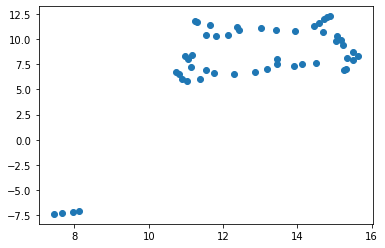

In [87]:
plt.scatter(embedding[:,0], embedding[:,1]);

### Con HDBSCAN

In [88]:
hdbscan = HDBSCAN(min_cluster_size=7)
clustering = hdbscan.fit_predict(embedding)
np.unique(clustering)

array([-1,  0,  1])

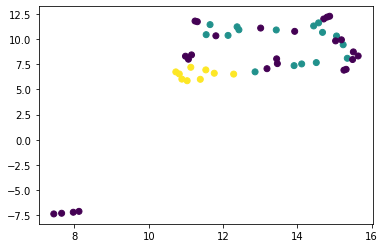

In [89]:
plt.scatter(embedding[:,0], embedding[:,1], c=clustering);

In [90]:
games = pd.DataFrame({'cluster': clustering, 'title': gamereactor_df['title'], 'synopsis': synopses})

In [91]:
games.head(8)

,cluster,title,synopsis
0,0,Kingdoms of Amalur: Re-Reckoning,Sé que no todo el mundo lo recibió igual de bi...
1,-1,Tennis World Tour 2 - Iguales,Habían pasado muchos años sin que los fans de ...
2,0,Hades,El periplo por un limbo llamado acceso anticip...
3,-1,Necronator: Dead Wrong,Hace unos meses le eché un vistazo a un RTS có...
4,-1,Los Sims 4 Star Wars: Viaje a Batuu,Los Sims y Star Wars por fin se unen. Un sueño...
5,0,Spelunky 2 - Hasta la muerte,A parte de un juegos de Bungie con los que me ...
6,1,Crysis Remastered,Crysis cayó como un bombazo hace 13 años. El e...
7,1,Super Mario 3D All-Stars,"Felicidades, Super Mario. Por tus 35 años de s..."


In [92]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)
tfidf_df.head()

,a,abandonar,abrir,acabar,accionar,activar,afectar,agradecer,alcanzar,alguien,...,viajar,vida,videojuego,viejo,visual,vivir,volver,voz,xbox,zona
0,0.399389,0.0,0.000000,0.041657,0.000000,0.072811,0.0,0.0,0.000000,0.0,...,0.000000,0.136827,0.0,0.06302,0.000000,0.000000,0.038217,0.0,0.126041,0.000000
1,0.548031,0.0,0.052277,0.000000,0.000000,0.000000,0.0,0.0,0.065496,0.0,...,0.000000,0.000000,0.0,0.00000,0.000000,0.048229,0.000000,0.0,0.000000,0.000000
2,0.531969,0.0,0.000000,0.000000,0.066124,0.000000,0.0,0.0,0.063576,0.0,...,0.000000,0.041420,0.0,0.00000,0.101491,0.046816,0.069413,0.0,0.000000,0.000000
3,0.560077,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,0.599720,0.0,0.048407,0.036088,0.063077,0.000000,0.0,0.0,0.000000,0.0,...,0.303232,0.039511,0.0,0.00000,0.000000,0.044658,0.033107,0.0,0.000000,0.087066


In [93]:
def get_df_from_cluster(cluster):
    return tfidf_df[clustering==cluster]

get_df_from_cluster(0)

,a,abandonar,abrir,acabar,accionar,activar,afectar,agradecer,alcanzar,alguien,...,viajar,vida,videojuego,viejo,visual,vivir,volver,voz,xbox,zona
0,0.399389,0.000000,0.000000,0.041657,0.000000,0.072811,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.136827,0.000000,0.063020,0.000000,0.000000,0.038217,0.000000,0.126041,0.000000
2,0.531969,0.000000,0.000000,0.000000,0.066124,0.000000,0.000000,0.000000,0.063576,0.000000,...,0.000000,0.041420,0.000000,0.000000,0.101491,0.046816,0.069413,0.000000,0.000000,0.000000
5,0.550032,0.000000,0.048096,0.071712,0.000000,0.000000,0.000000,0.000000,0.000000,0.062672,...,0.000000,0.157030,0.000000,0.054244,0.000000,0.000000,0.032895,0.000000,0.000000,0.000000
10,0.464508,0.079390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.057697,0.068715,0.000000,0.056208,0.000000,0.000000,0.068715,0.000000
13,0.555339,0.060745,0.000000,0.034754,0.000000,0.000000,0.000000,0.121490,0.000000,0.000000,...,0.000000,0.076101,0.044147,0.000000,0.046618,0.000000,0.063767,0.056288,0.052577,0.041924
17,0.602229,0.049905,0.000000,0.028552,0.000000,0.000000,0.000000,0.000000,0.000000,0.099809,...,0.143946,0.093781,0.000000,0.000000,0.038298,0.035332,0.026194,0.000000,0.000000,0.034442
22,0.426569,0.000000,0.089520,0.066738,0.058325,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.073069,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
24,0.594779,0.000000,0.034673,0.000000,0.000000,0.000000,0.045180,0.000000,0.000000,0.090360,...,0.260636,0.113203,0.000000,0.000000,0.034673,0.031987,0.023714,0.000000,0.000000,0.000000
26,0.467368,0.000000,0.000000,0.139278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.052676,0.000000,0.000000,0.031944,0.056394,0.000000,0.042003
29,0.366499,0.000000,0.000000,0.076453,0.000000,0.066815,0.000000,0.066815,0.000000,0.000000,...,0.192723,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [94]:
top_words_cluster = get_df_from_cluster(0).T.sum(axis=1).sort_values(ascending=False)
top_words_cluster.head()

a        8.077056
parir    3.356007
comer    2.106116
jugar    2.095982
o        1.602285
dtype: float64

In [95]:
games[games['cluster'] == 0].title

0                      Kingdoms of Amalur: Re-Reckoning
2                                                 Hades
5                          Spelunky 2 - Hasta la muerte
10            Pathfinder: Kingmaker para PS4 y Xbox One
13                         Tell Me Why - Juego Completo
17                                           Struggling
22                 Iron Harvest - La guerra nunca acaba
24                                          Spiritfarer
26                                          Wasteland 3
29               Remnant: From the Ashes - Subject 2923
34             Peaky Blinders: Mastermind - La precuela
38                                 Total War Saga: Troy
45                                           Fairy Tail
46                         Carrion - Asquerosa venganza
47    Rock of Ages 3: Make & Break - A pedradas con ...
48                                            Mutazione
Name: title, dtype: object

### Con DBSCAN

In [104]:
from sklearn.cluster import DBSCAN

dbscan_c = DBSCAN(eps=1,
                  min_samples=5).fit(embedding)

dbscan_c

DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

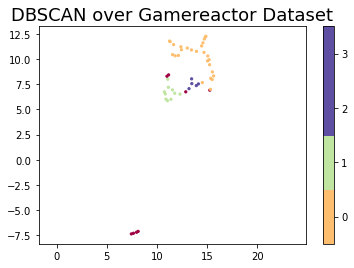

In [116]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=dbscan_c.labels_, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(len(np.unique(dbscan_c.labels_)) + 1) - 0.5).set_ticks(np.arange(len(np.unique(dbscan_c.labels_))))
plt.title('DBSCAN over Gamereactor Dataset', fontsize=18);

In [113]:
games = pd.DataFrame({'cluster': dbscan_c.labels_, 'title': gamereactor_df['title'], 'synopsis': synopses})

In [115]:
games.head(12)

,cluster,title,synopsis
0,0,Kingdoms of Amalur: Re-Reckoning,Sé que no todo el mundo lo recibió igual de bi...
1,0,Tennis World Tour 2 - Iguales,Habían pasado muchos años sin que los fans de ...
2,0,Hades,El periplo por un limbo llamado acceso anticip...
3,-1,Necronator: Dead Wrong,Hace unos meses le eché un vistazo a un RTS có...
4,0,Los Sims 4 Star Wars: Viaje a Batuu,Los Sims y Star Wars por fin se unen. Un sueño...
5,0,Spelunky 2 - Hasta la muerte,A parte de un juegos de Bungie con los que me ...
6,1,Crysis Remastered,Crysis cayó como un bombazo hace 13 años. El e...
7,1,Super Mario 3D All-Stars,"Felicidades, Super Mario. Por tus 35 años de s..."
8,0,13 Sentinels: Aegis Rim,13 Sentinels: Aegis Rim cuenta una historia co...
9,1,eFootball PES 2021- Season Update,Septiembre siempre es un mes señalado para los...


In [121]:
games[games['cluster'] == -1].title

3                        Necronator: Dead Wrong
10    Pathfinder: Kingmaker para PS4 y Xbox One
25       Captain Tsubasa: Rise of New Champions
27                           RimWorld - Royalty
28                               Project Cars 3
32                                PGA Tour 2K21
41                 Fall Guys: Ultimate Knockout
44       Beyond Blue - Un videojuego documental
Name: title, dtype: object

<div style="padding-top: 25px; float: right">
    <div>    
        <i>&nbsp;&nbsp;© Copyright by</i>
    </div>
    <div>
        <a href="https://whiteboxml.com">
            <img src="https://whiteboxml.com/static/img/logo/black_bg_white.svg" width="125">
        </a>
    </div>
</div>